In [21]:
!pip install xgboost shap lime scikit-learn pandas numpy matplotlib seaborn

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
csv_path = ('/content/drive/MyDrive/CreditRiskProject/credit_risk_dataset.csv')

In [28]:
import pandas as pd

df = pd.read_csv(csv_path)
df.head()


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [29]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

df['loan_status'] = df['loan_status'].astype(int)

df.fillna(df.median(numeric_only=True), inplace=True)

cat_cols = df.select_dtypes(include=['object']).columns
encoders = {}

for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    encoders[col] = le

df.head()


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,3,123.0,4,3,35000,16.02,1,0.59,1,3
1,21,9600,2,5.0,1,1,1000,11.14,0,0.10,0,2
2,25,9600,0,1.0,3,2,5500,12.87,1,0.57,0,3
3,23,65500,3,4.0,3,2,35000,15.23,1,0.53,0,2
4,24,54400,3,8.0,3,2,35000,14.27,1,0.55,1,4


In [30]:
df['income_to_loan_ratio'] = df['person_income'] / (df['loan_amnt'] + 1)
df['credit_age_interaction'] = df['person_age'] * df['cb_person_cred_hist_length']


In [31]:
from sklearn.model_selection import train_test_split

X = df.drop('loan_status', axis=1)
y = df['loan_status']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [32]:
from xgboost import XGBClassifier

model = XGBClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss'
)

model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, ...)

In [33]:
from sklearn.metrics import roc_auc_score, classification_report, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


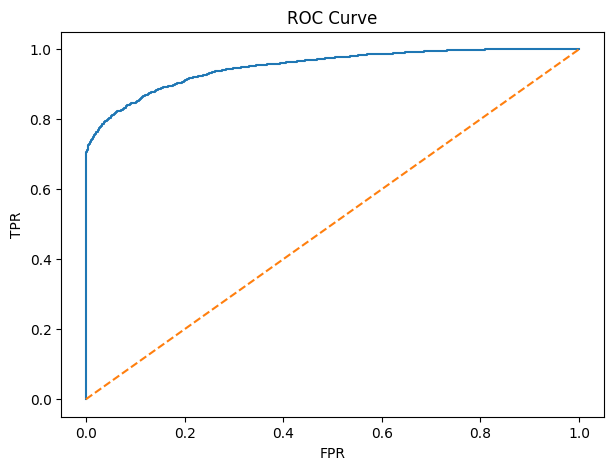

AUC Score: 0.9499818497768833


In [34]:
y_pred_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")

plt.savefig(f"{plots_path}/roc_curve.png")
plt.show()

print("AUC Score:", roc_auc_score(y_test, y_pred_proba))


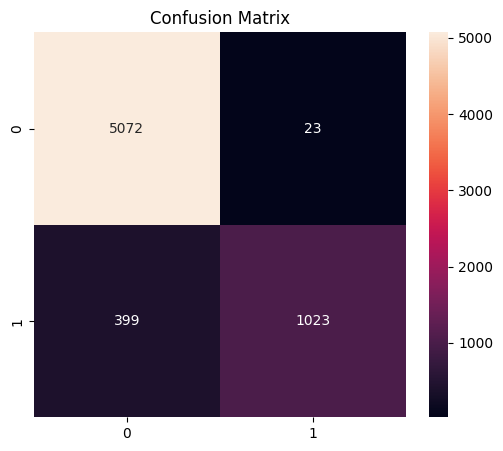

              precision    recall  f1-score   support

           0       0.93      1.00      0.96      5095
           1       0.98      0.72      0.83      1422

    accuracy                           0.94      6517
   macro avg       0.95      0.86      0.89      6517
weighted avg       0.94      0.94      0.93      6517



In [35]:
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d')
plt.title("Confusion Matrix")

plt.savefig(f"{plots_path}/confusion_matrix.png")
plt.show()

print(classification_report(y_test, y_pred))


In [36]:
import shap
shap.initjs()

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)


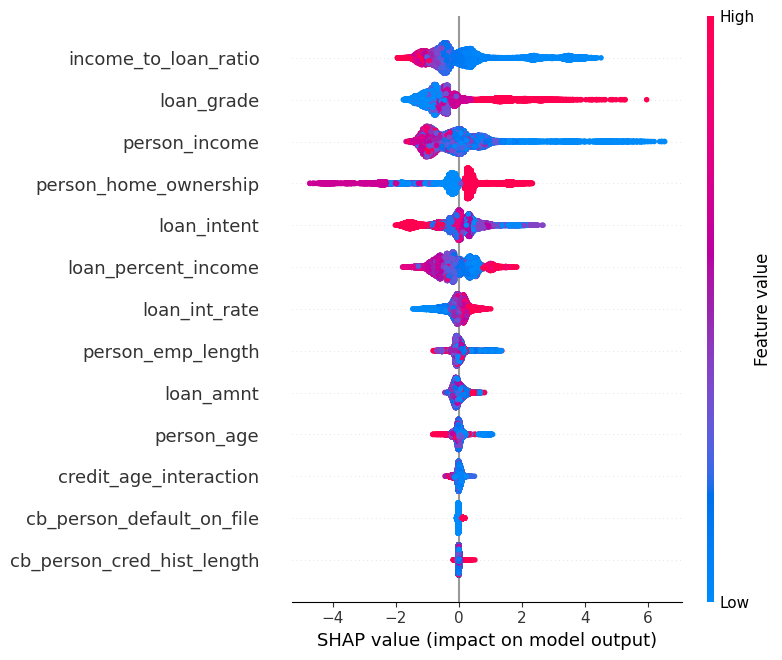

In [37]:
plt.figure()
shap.summary_plot(shap_values, X_train, show=False)
plt.savefig(f"{plots_path}/shap_summary.png", bbox_inches='tight')
plt.show()


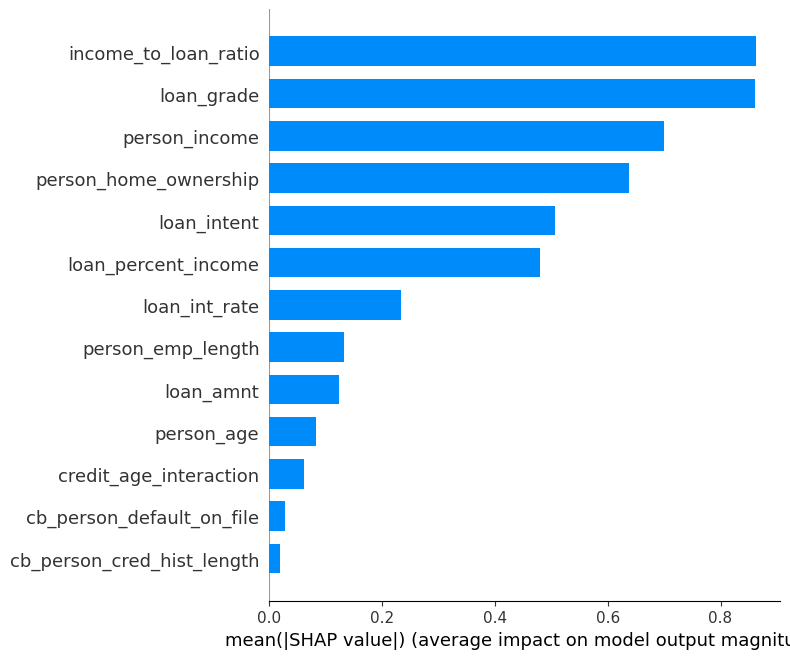

In [38]:
plt.figure()
shap.summary_plot(shap_values, X_train, plot_type="bar", show=False)
plt.savefig(f"{plots_path}/shap_bar.png", bbox_inches='tight')
plt.show()


In [39]:
high_risk_index = X_test[y_test==1].sample(1, random_state=42).index[0]
low_risk_index = X_test[y_test==0].sample(1, random_state=42).index[0]

probs = pd.Series(y_pred_proba, index=X_test.index)
borderline_index = probs.sub(0.5).abs().sort_values().index[0]

instance_indices = {
    "high_risk": high_risk_index,
    "low_risk": low_risk_index,
    "borderline": borderline_index
}

instance_indices


{'high_risk': np.int64(8610),
 'low_risk': np.int64(8622),
 'borderline': np.int64(25907)}

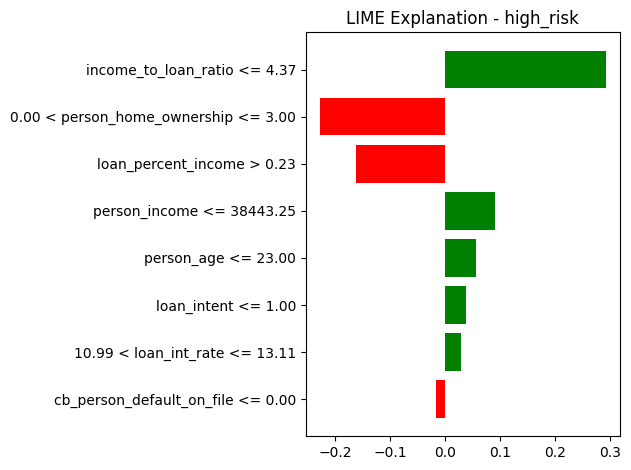

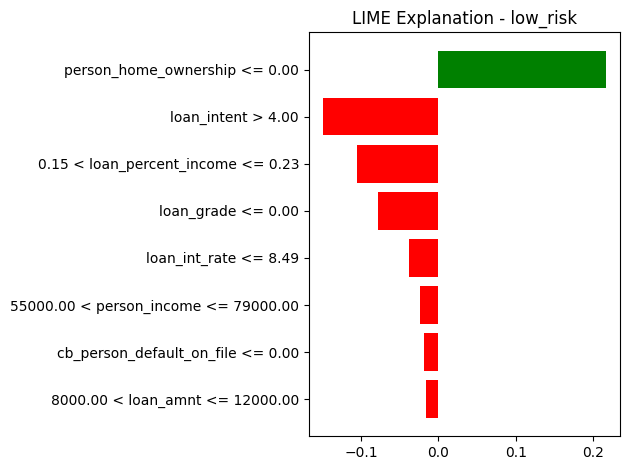

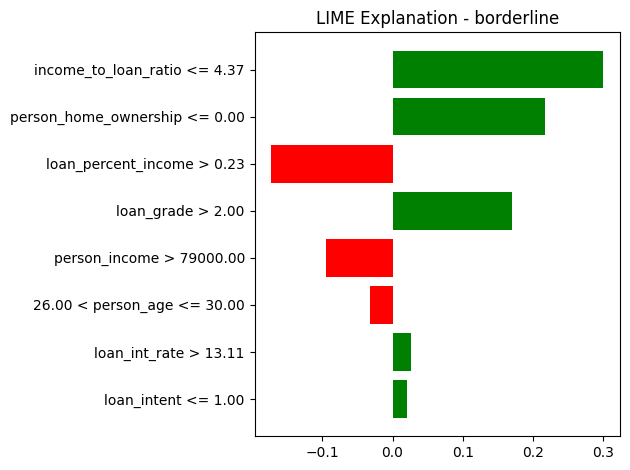

In [40]:
from lime.lime_tabular import LimeTabularExplainer

explainer_lime = LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns,
    class_names=['Safe','Risky'],
    mode='classification'
)

for name, idx in instance_indices.items():
    exp = explainer_lime.explain_instance(
        X_test.loc[idx].values,
        model.predict_proba,
        num_features=8
    )

    fig = exp.as_pyplot_figure()
    plt.title(f"LIME Explanation - {name}")
    plt.tight_layout()
    plt.savefig(f"{plots_path}/lime_{name}.png")
    plt.show()


<Figure size 640x480 with 0 Axes>

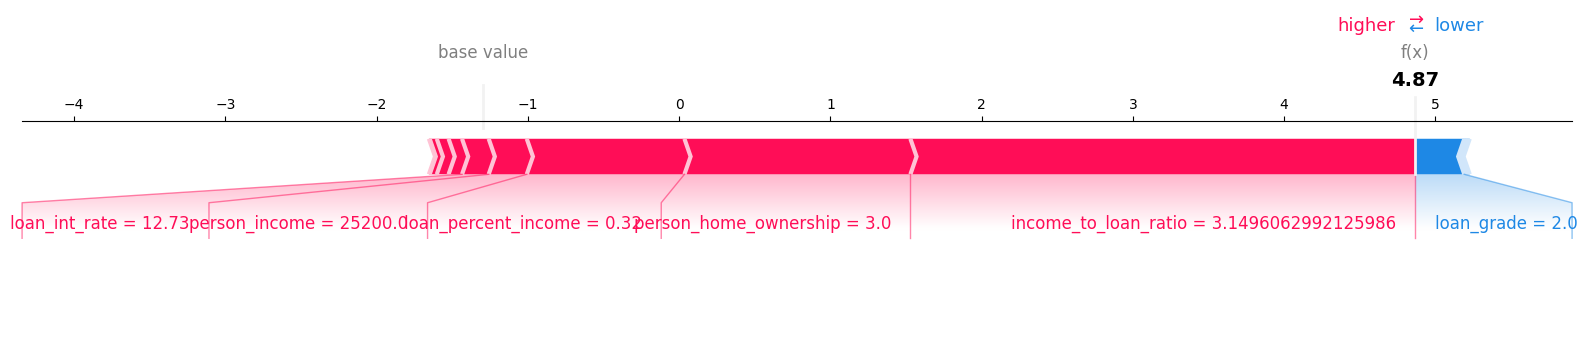

<Figure size 640x480 with 0 Axes>

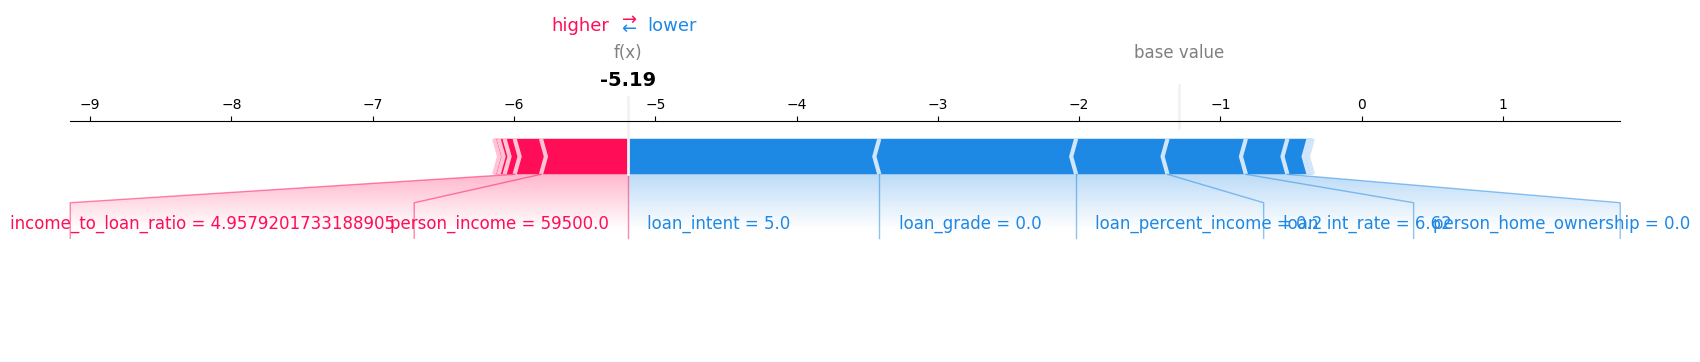

<Figure size 640x480 with 0 Axes>

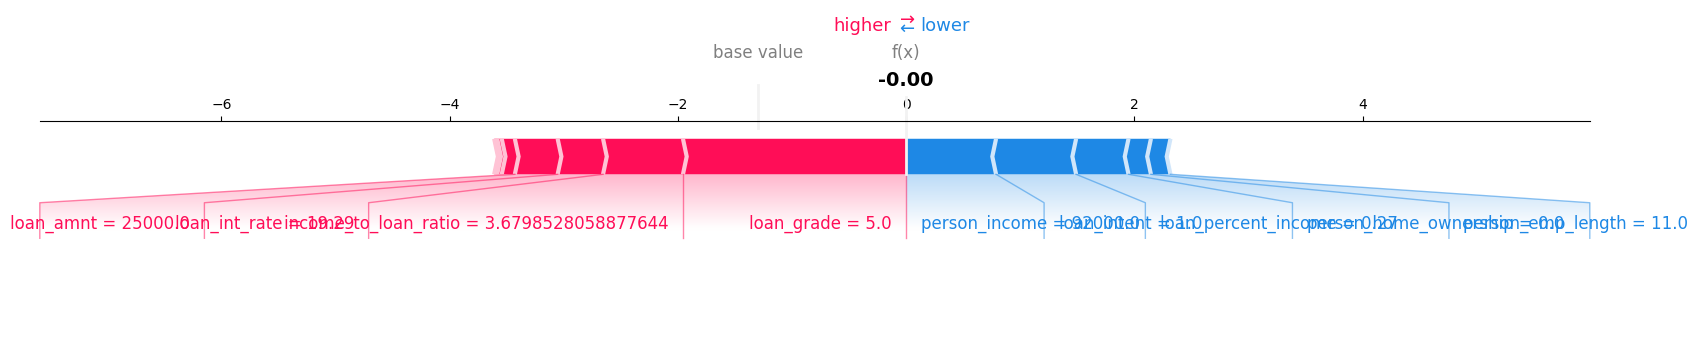

In [41]:
for name, idx in instance_indices.items():
    shap_value = explainer.shap_values(X_test.loc[[idx]])

    plt.figure()
    shap.force_plot(
        explainer.expected_value,
        shap_value,
        X_test.loc[[idx]],
        matplotlib=True,
        show=False
    )
    plt.savefig(f"{plots_path}/shap_force_{name}.png", bbox_inches='tight')
    plt.show()


In [42]:
with open(f"{project_path}/model_parameters.txt", "w") as f:
    f.write(str(model.get_params()))
